In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

# load general packages
import numpy as np

# load modules related to this exercise
from  matplotlib.pyplot import spy
from model_zucher import zurcher
import Estimate_MPEC_exante as estimate_MPEC

from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate_NFXP

# Exercise set 4


In [2]:
# setup
do_settings = {
    'n': 90
}
model = zurcher(**do_settings)
solver = solve_NFXP()


#  SIMULATE DATA
N = 500
T = 120
ev, pk = solver.poly(model.bellman, beta=model.beta, output=2)
data = zurcher.sim_data(model,N,T,pk) 
samplesize = data.shape[0]


#### 1. Run the function mpec.sparsity_pattern.
The function mpec.sparsity_pattern creates sparse matrices of indicators for where there are elements in the Jacobian of the constraints and Hessian of the likelihood function

(a) Look at the figures, and talk about what the different elements of the Jacobian of the constraint and Hessian of the likelihood represent.

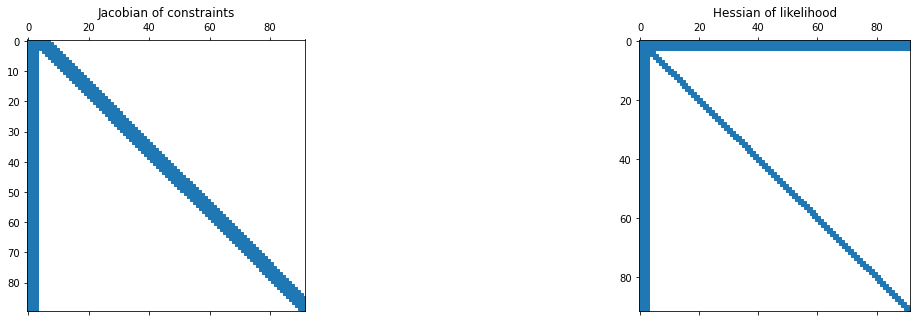

In [3]:
# Number of parameter to be estimated
Nc = 2


import matplotlib.pyplot as plt

J_pattern, H_pattern = estimate_MPEC.sparsity_pattern(Nc,model.n, len(model.p)+1)

# Figure
fig = plt.figure(figsize=(20,5))# figsize is in inches...

ax = fig.add_subplot(1,2,1)
ax.spy(J_pattern,markersize=5)
ax.set_title(f'Jacobian of constraints')
ax = fig.add_subplot(1,2,2)
ax.spy(H_pattern,markersize=5)
ax.set_title(f'Hessian of likelihood')
plt.show()

#### 2. What is the advantages of handle that the Jacobian and Hessian as sparse matrices?

#### 3. Estimate the model using MPEC. In order to estimate the model, you should understand:
<il type ="a">
<li> Estimate_MPEC.estimate </li>
<li> Estimate_MPEC.ll (don't spend too much time on understanding the gradient)</li>
<li> Estimate_MPEC.con_bellman (don't focus too much on computing Jacobian) </li>
</il>

Note that we in the implemenation don't use the information that the Hessian is sparse.

#### 4. Fill in the missing stuff in mpec.ll and mpec.con_bellman, and run the code to check that your results are correct

In [4]:
import time

theta0 = [11,2]


t0 = time.time()
res_MPEC, pnames, theta_hat_MPEC = estimate_MPEC.estimate(model,data,theta0=theta0, twostep=1)
t1 = time.time()
time_MPEC=t1-t0


# Print the results
print(f'Structual estimation using busdata from Rust(1987)')
print(f'Beta        = {model.beta:.4f}')
print(f'n           = {model.n}')
print(f'Sample size = {data.shape[0]}\n \n') 

print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}             {theta_hat_MPEC[0]:.4f}     ')
print(f'{pnames[1]}              {theta_hat_MPEC[1]:.4f}      \n ')


print(f'Log-likelihood {-res_MPEC.fun*samplesize:.4f}')  
print(f'runtime (seconds) {time_MPEC:.4f}')
print(res_MPEC.message)

Structual estimation using busdata from Rust(1987)
Beta        = 0.9999
n           = 90
Sample size = 60000
 

Parameters     Estimates    s.e. 
RC             11.9833     
c              2.5462      
 
Log-likelihood -1896.1880
runtime (seconds) 9.2279
`gtol` termination condition is satisfied.


In [5]:
%lprun -f estimate_MPEC.ll  -f estimate_MPEC.estimate -f estimate_MPEC.con_bellman -f estimate_MPEC.constraint_jac estimate_MPEC.estimate(model,data,theta0=theta0, twostep=1)

Timer unit: 1e-07 s

Total time: 9.10989 s
File: c:\Users\Asker\OneDrive - Københavns Universitet\Documents\Uni\10. semester\Dynamic Programming\dp_ucph\2_dynamic_discrete_choice\exercises\work\02_MPEC\Estimate_MPEC_exante.py
Function: estimate at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
    23                                           def estimate(model, data, theta0 = [0,0],twostep=0):
    24         1         50.0     50.0      0.0      assert(twostep == 1),'MPEC only implemented for twostep=1'
    25                                           
    26                                           
    27                                               # Setup
    28         1         16.0     16.0      0.0      pnames = ['RC','c']
    29                                           
    30         1        190.0    190.0      0.0      class data_class: pass
    31         1     235783.0 235783.0      0.3      data_class.xd = np.nan+np.zeros((model.n,data.d.size,

#### 5. Compare NFXP and MPEC:

In [6]:
# Solve by NFXP
model = zurcher(**do_settings)
solver = solve_NFXP()


t0 = time.time()
nfxp_model, nfxp_results, pnames, theta_hat_NFXP, Avar_NFXP, converged=estimate_NFXP.estimate(model, solver, data, theta0=theta0, twostep=1)
t1 = time.time()
time_NFXP=t1-t0


#compare the results 
print(f'Structual estimation using busdata from Rust(1987) \n')

print(f'MPEC')
print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}             {theta_hat_MPEC[0]:.4f}     ')
print(f'{pnames[1]}              {theta_hat_MPEC[1]:.4f}      \n ')


print(f'Log-likelihood {-res_MPEC.fun*samplesize:.2f}')
print(f'runtime (seconds) {time_MPEC:.4f}\n \n')


print(f'NFXP')
print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}             {theta_hat_NFXP[0]:.4f}     {np.sqrt(Avar_NFXP[0,0]):.4f}      ')
print(f'{pnames[1]}              {theta_hat_NFXP[1]:.4f}      {np.sqrt(Avar_NFXP[1,1]):.4f}       \n ')


print(f'Log-likelihood {-nfxp_results.fun*samplesize:.2f}')
print(f'runtime (seconds) {time_NFXP:.4f}')

Structual estimation using busdata from Rust(1987) 

MPEC
Parameters     Estimates    s.e. 
RC             11.9833     
c              2.5462      
 
Log-likelihood -1896.19
runtime (seconds) 9.2279
 

NFXP
Parameters     Estimates    s.e. 
RC             12.0888     0.8966      
c              2.5873      0.3075       
 
Log-likelihood -1896.18
runtime (seconds) 0.3277


(a) Compare the time of NFXP and the time of MPEC, and the time of NFXP and MPEC from the lecture. According to what you saw at the lectures the two methods should be comparable with regards to speed.

In [7]:
print(f'Beta        = {model.beta:.4f}')
print(f'n           = {model.n}')


%timeit estimate_NFXP.estimate(model, solver, data, theta0=theta0, twostep=1)


Beta        = 0.9999
n           = 90
357 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit estimate_MPEC.estimate(model,data,theta0=theta0, twostep=1)

7.21 s ± 61.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(b) Do we use analytical first-order derivatives? 

Yes

(c) What about second-order derivatives? 

No

(d) What do they do in Su and Judd (2012)? 

They do

(e) Why is our implementation inefficient?

Laziness

Non-optimal solvers


#### 5. How did we get our standard errors using NFXP? How would you calculate them using MPEC?

From slides:

MPEC: Standard errors can be computed inverting the bordered Hessian
Reich and Judd (2019)